In [3]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, jarque_bera
from scipy.linalg import lstsq
import linearmodels as lm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

ModuleNotFoundError: No module named 'linearmodels'

<p style="text-align:center">
    <a href="https://www.wits.ac.za/" target="_blank">
    <img src="	https://www.wits.ac.za/media/wits-university-style-assets/images/wits-logo.svg" width="200" alt="University of witwatersrand Logo"  />
    </a>
</p>

## Completed by: Neo Mmusi

In [2]:
data=pd.read_excel('Univariate - TS.xlsx',index_col=0)

In [3]:
data

,JALSH Index,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity,Tbill - 91
2001-01-31,8942.43,2285.53,1004.91,15443.40,0.008433
2001-02-28,8916.34,1845.78,969.59,15767.63,0.008442
2001-03-31,8093.84,1553.58,947.12,11990.29,0.008600
2001-04-30,8902.39,1533.33,1054.72,16106.35,0.008667
2001-05-31,9270.90,1735.85,1105.57,18790.75,0.008633
...,...,...,...,...,...
2024-04-30,76076.17,360737.00,17709.00,65265.89,0.007100
2024-05-31,76704.26,372833.00,17918.00,60217.14,0.007175
2024-06-30,79707.11,356722.00,21081.00,59346.26,0.007175
2024-07-31,82765.12,352221.00,22178.00,69680.47,0.006942


#### 1. Download Data and convert all levels to returns 

We have downloaded the data and now want to convert all level data to returns. We can do this with the dataframe *pct_change* function. Remember, we have included the risk-free rate data which is already a return so that gets excluded. What we intend to do is run a regression of the form:
$$
Y_{i,t}-r_{f} = \alpha_{i} + \beta_{i} (JSE_{t}-r_{f}) + \varepsilon_{i,t}
$$

In order to run the regressions we need to check:
1) Are data stationary?
2) Are variables normal?

**We will first look at the descriptive statistics, then plot data afterwhich we can run regressions!**

In [4]:
lvl_data=data.iloc[:,:-1]

In [5]:
lvl_data

,JALSH Index,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity
2001-01-31,8942.43,2285.53,1004.91,15443.40
2001-02-28,8916.34,1845.78,969.59,15767.63
2001-03-31,8093.84,1553.58,947.12,11990.29
2001-04-30,8902.39,1533.33,1054.72,16106.35
2001-05-31,9270.90,1735.85,1105.57,18790.75
...,...,...,...,...
2024-04-30,76076.17,360737.00,17709.00,65265.89
2024-05-31,76704.26,372833.00,17918.00,60217.14
2024-06-30,79707.11,356722.00,21081.00,59346.26
2024-07-31,82765.12,352221.00,22178.00,69680.47


In [8]:
rfr=data.iloc[:,-1]

In [9]:
rfr

2001-01-31    0.008433
2001-02-28    0.008442
2001-03-31    0.008600
2001-04-30    0.008667
2001-05-31    0.008633
                ...   
2024-04-30    0.007100
2024-05-31    0.007175
2024-06-30    0.007175
2024-07-31    0.006942
2024-08-31    0.006942
Name: Tbill - 91, Length: 284, dtype: float64

<Axes: >

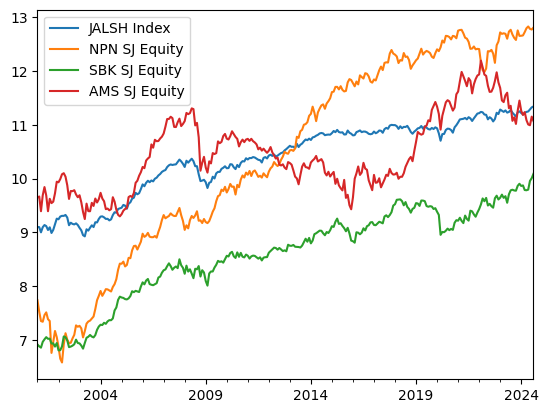

In [12]:
np.log(lvl_data).plot()
# plt.savefig('lr_fig1.png',dpi=300,bbox_inches='tight')

We can see that level data are not stationary as they display a clear pattern and definitely don't oscillate around 0

In [17]:
lvl_data.pct_change().drop(lvl_data.index[0]).sub(rfr,axis='rows').dropna()

,JALSH Index,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity
2001-02-28,-0.011359,-0.200848,-0.043589,0.012553
2001-03-31,-0.100846,-0.166907,-0.031775,-0.248163
2001-04-30,0.091230,-0.021701,0.104941,0.334616
2001-05-31,0.032761,0.123445,0.039579,0.158034
2001-06-30,-0.027566,0.043622,0.033503,-0.153280
...,...,...,...,...
2024-04-30,0.013564,0.067305,-0.011401,-0.146009
2024-05-31,0.001081,0.026356,0.004627,-0.084532
2024-06-30,0.031973,-0.050387,0.169351,-0.021637
2024-07-31,0.031424,-0.019559,0.045096,0.167192


In [13]:
ret_data=lvl_data.pct_change().drop(lvl_data.index[0])

In [18]:
exc_ret=ret_data.subtract(data.iloc[:,-1],axis='rows').dropna()

In [19]:
exc_ret

,JALSH Index,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity
2001-02-28,-0.011359,-0.200848,-0.043589,0.012553
2001-03-31,-0.100846,-0.166907,-0.031775,-0.248163
2001-04-30,0.091230,-0.021701,0.104941,0.334616
2001-05-31,0.032761,0.123445,0.039579,0.158034
2001-06-30,-0.027566,0.043622,0.033503,-0.153280
...,...,...,...,...
2024-04-30,0.013564,0.067305,-0.011401,-0.146009
2024-05-31,0.001081,0.026356,0.004627,-0.084532
2024-06-30,0.031973,-0.050387,0.169351,-0.021637
2024-07-31,0.031424,-0.019559,0.045096,0.167192


In [20]:
exc_ret.describe()

,JALSH Index,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity
count,283.000000,283.000000,283.000000,283.000000
mean,0.003037,0.016844,0.007758,0.007127
std,0.047281,0.098026,0.071039,0.127301
min,-0.148818,-0.455177,-0.314633,-0.471282
25%,-0.029010,-0.041920,-0.035016,-0.080815
50%,0.004716,0.011370,0.004570,0.009031
75%,0.032886,0.075149,0.050143,0.072266
max,0.130304,0.393318,0.247241,0.408953


<Axes: >

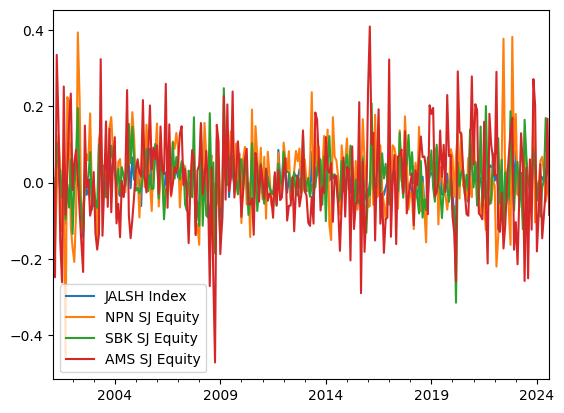

In [21]:
exc_ret.plot()

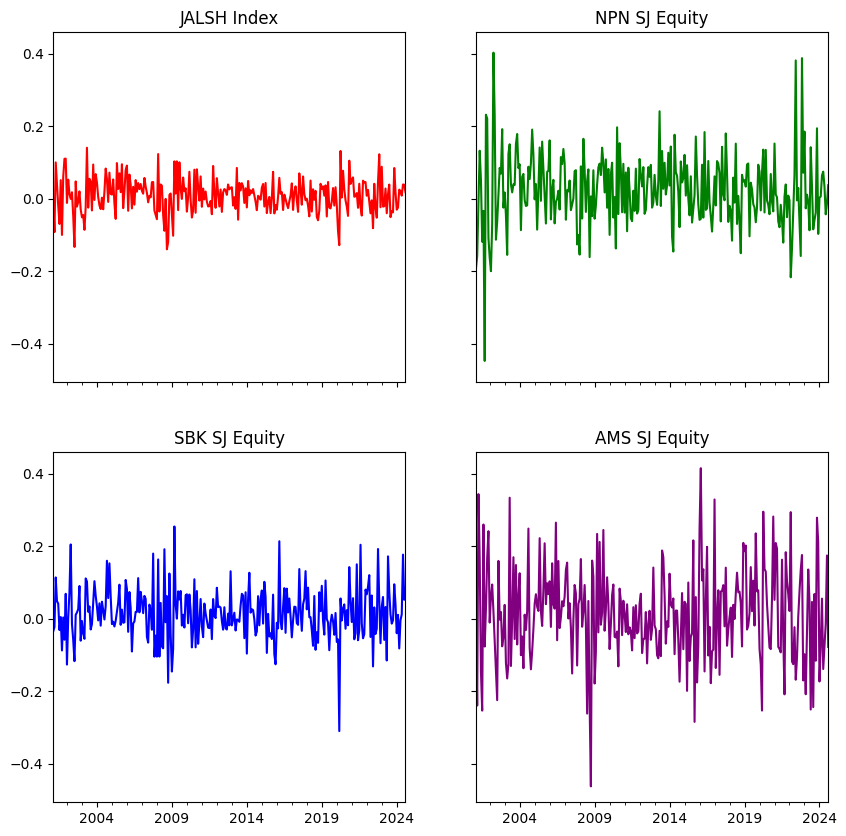

In [22]:
fig,axs=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
for c,ax,colr in zip(exc_ret.columns,fig.axes,['r','g','b','purple']):
    ret_data.loc[:,c].plot(ax=ax,color=colr)
    ax.set_title(c)
# plt.savefig('lr_fig2.png',dpi=300,bbox_inches='tight')

The above graphic shows that data looks stationary around zero however series display significant volatility!

#### 2. Test whether series are stationary using the Augmented Dickey-Fuller test
To test whether returns are stationary, we will use the ADF test which is available in the statsmodels library. We are really just testing whether the return series have a memory i.e. do returns contain information about the next return. If they do, then they have a level of autocorrelation that would result in heteroskedasticity and render regression outputs unusable. For the ADF, the null and alternative are:

$$
H_{0}: \text{Time-series has a unit root (is non-stationary)}
$$
$$
H_{A}: \text{Time-series does not have a unit root (is stationary)}
$$
We can run the test for a single series and then apply a *"loop"* to loop through each set of returns

In [26]:
adfuller(exc_ret.iloc[:,0])[1]

5.2327146442041725e-30

The second item (at index 1) is the p-value

In [27]:
# Here's the loop
adf_all={c:adfuller(exc_ret.loc[:,c])[1] for c in exc_ret.columns}

In [28]:
adf_all

{'JALSH Index': 5.2327146442041725e-30,
 'NPN SJ Equity': 1.439423659053171e-06,
 'SBK SJ Equity': 2.590132153333055e-30,
 'AMS SJ Equity': 1.6445828770135224e-29}

In [ ]:
# pd.Series(adf_all).to_excel('ADF.xlsx')

The above ADF p-values all reject the null hypothesis at the 1% therefore ***all return series are stationary***

#### 3. Normality tests
We can now test whether the series are normal. Importantly, if series are approximately normal we are happy to continue with the regressions

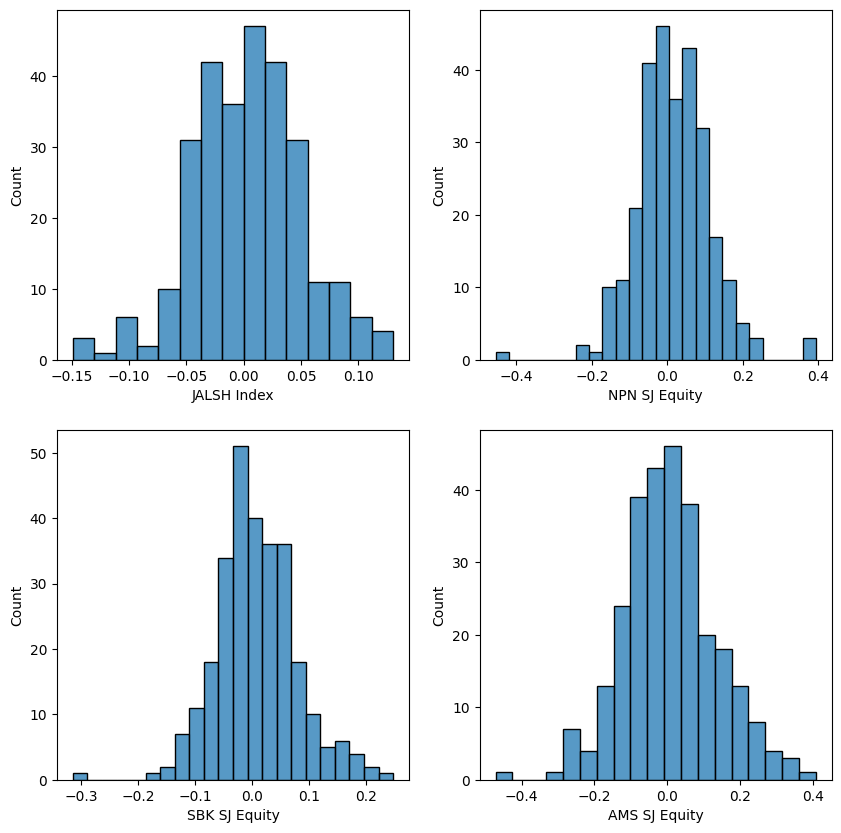

In [29]:
fig,axs=plt.subplots(2,2,figsize=(10,10))
for c,ax in zip(exc_ret.columns,fig.axes):
    sbn.histplot(exc_ret.loc[:,c],ax=ax)
# plt.savefig('lr_fig3.png',dpi=300,bbox_inches='tight')

**All series are the typical bell shape, but we can formally test whether the underlying returns are 'officially' normal by using the Shapiro-Wilk test or the Jarque-Bera test, both of which are available in the scipy library**. For both tests, the null and alternative are as follows:
$$
H_{0}: \text{Sample data are drawn from a normal distribution}
$$
$$
H_{A}: \text{Sample data are not drawn from a normal distribution}
$$


In [30]:
shapiro(exc_ret.iloc[:,0])

ShapiroResult(statistic=0.9894824369776756, pvalue=0.03856122555321914)

In [31]:
jarque_bera(exc_ret.iloc[:,0])

SignificanceResult(statistic=3.877452500170487, pvalue=0.14388710929642934)

Both tests are run on the JSE excess returns. Shapiro-Wilk rejects the null while Jarque-Bera fails to reject the null

In [32]:
shap_tst_out={}
jb_tst_out={}
for c in exc_ret.columns:
    outp_shp={}
    outp_shp['stat']=shapiro(ret_data.loc[:,c])[0]
    outp_shp['p-val']=shapiro(ret_data.loc[:,c])[1]
    shap_tst_out[c]=outp_shp
    outp_jb={}
    outp_jb['stat']=jarque_bera(ret_data.loc[:,c])[0]
    outp_jb['p-val']=jarque_bera(ret_data.loc[:,c])[1]
    jb_tst_out[c]=outp_jb

In [33]:
shap_tst_out

{'JALSH Index': {'stat': 0.9899061666944334, 'p-val': 0.04732367932707272},
 'NPN SJ Equity': {'stat': 0.9684307403848337, 'p-val': 7.110305585420955e-06},
 'SBK SJ Equity': {'stat': 0.9790989075571173,
  'p-val': 0.00036888158089613864},
 'AMS SJ Equity': {'stat': 0.9927062179400034, 'p-val': 0.18118349361492242}}

In [34]:
jb_tst_out

{'JALSH Index': {'stat': 3.3476339724219715, 'p-val': 0.18752989876370474},
 'NPN SJ Equity': {'stat': 86.81025930404742, 'p-val': 1.4105604601260275e-19},
 'SBK SJ Equity': {'stat': 34.36934188141764, 'p-val': 3.441852360139841e-08},
 'AMS SJ Equity': {'stat': 3.603171811478214, 'p-val': 0.16503694752761336}}

In [35]:
# pd.DataFrame(shap_tst_out)

In [36]:
# pd.DataFrame(jb_tst_out)

### Run Regressions either using statsmodels or linearmodels 
Using statsmodels or linearmodels, we can run linear regressions to determine alphas and betas of NPN, SBK and AMS

In [37]:
emrp=exc_ret.iloc[:,0]
shrs_er=exc_ret.iloc[:,1:]

In [44]:
shrs_er

,NPN SJ Equity,SBK SJ Equity,AMS SJ Equity
2001-02-28,-0.200848,-0.043589,0.012553
2001-03-31,-0.166907,-0.031775,-0.248163
2001-04-30,-0.021701,0.104941,0.334616
2001-05-31,0.123445,0.039579,0.158034
2001-06-30,0.043622,0.033503,-0.153280
...,...,...,...
2024-04-30,0.067305,-0.011401,-0.146009
2024-05-31,0.026356,0.004627,-0.084532
2024-06-30,-0.050387,0.169351,-0.021637
2024-07-31,-0.019559,0.045096,0.167192


Importantly, if we want to also estimate alpha in our regressions, we need to modify X using the sm.tools.add_const function

In [42]:
emrp_adj=sm.tools.add_constant(emrp)

In [43]:
emrp_adj

,const,JALSH Index
2001-02-28,1.0,-0.011359
2001-03-31,1.0,-0.100846
2001-04-30,1.0,0.091230
2001-05-31,1.0,0.032761
2001-06-30,1.0,-0.027566
...,...,...
2024-04-30,1.0,0.013564
2024-05-31,1.0,0.001081
2024-06-30,1.0,0.031973
2024-07-31,1.0,0.031424


In [48]:
reg1=sm.OLS(shrs_er.iloc[:,0],emrp_adj).fit()

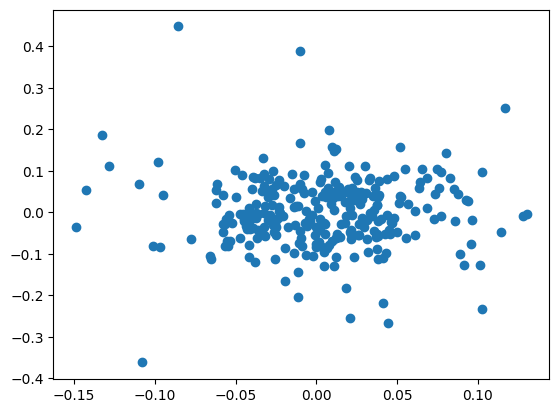

In [53]:
plt.scatter(emrp,reg1.resid)

In [54]:
#Running a single regression on NPN
model=sm.OLS(shrs_er.iloc[:,0],emrp_adj)
model_out=model.fit()

In [55]:
model_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NPN SJ Equity   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     83.76
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.18e-17
Time:                        16:05:57   Log-Likelihood:                 293.13
No. Observations:                 283   AIC:                            -582.3
Df Residuals:                     281   BIC:                            -575.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0138      0.005      2.693      0.008       0.004       0.024
JALSH Index     0.9935      0.109      9.152      0.000       0.780       1.207
==============================================================================
Omnibus:                       43.021   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.403
Skew:                           0.381   Prob(JB):                     9.42e-56
Kurtosis:                       7.573   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
model_out.mse_resid

0.007428856432546712

In [62]:
np.sum(model_out.resid**2)/(len(model_out.resid)-2)

0.00742885643254671

In [63]:
#Using a basic loop, we can run regressions for all shares
reg_out=[]
for c in shrs_er.columns:
    model=sm.OLS(shrs_er.loc[:,c],emrp_adj).fit()
    reg_out.append(model.summary())

In [64]:
reg_out

[<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:          NPN SJ Equity   R-squared:                       0.230
 Model:                            OLS   Adj. R-squared:                  0.227
 Method:                 Least Squares   F-statistic:                     83.76
 Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.18e-17
 Time:                        16:07:20   Log-Likelihood:                 293.13
 No. Observations:                 283   AIC:                            -582.3
 Df Residuals:                     281   BIC:                            -575.0
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 --------------------------------------------------------------------